In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as f
from torch.utils.data import DataLoader
import torchvision.models
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

In [3]:
torch.cuda.is_available()

True

In [4]:
def train_val_train_dataset(dataset, train_split):
    train_idx, remain_idx = train_test_split(list(range(len(dataset))), train_size=train_split)

    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['remain'] = Subset(dataset, remain_idx)
    val_idx,test_idx = train_test_split(list(range(len(datasets['remain']))), train_size=0.5)
    datasets['validation'] = Subset(dataset,val_idx)
    datasets['test'] = Subset(dataset,test_idx)
    return datasets

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
in_channels = 1
num_class = 54
learning_rate = 0.001
batch_size = 64
num_epochs = 50

In [7]:
# Load Data
dataset_path = './dataset_'
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
])
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=train_transforms)
dataset_split = train_val_train_dataset(dataset=dataset,train_split=0.6)
train_loader = DataLoader(dataset_split['train'],batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(dataset_split['validation'],batch_size = batch_size,shuffle=True)
test_loader = DataLoader(dataset_split['test'],batch_size=batch_size,shuffle=True)

In [9]:
model = torchvision.models.resnext50_32x4d(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=2048,out_features=54,bias=True)
model.to(device=device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [11]:
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    for batch_idx,(data,targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        print(data.shape)
        # forward
        scores = model(data)
        loss = criterion(scores,targets)

        # backward
        optimizer.zero_grad() # make gradient descent zero of the previous batch
        loss.backward()

        # gradient descent or adam stop
        optimizer.step()

epoch: 0
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
t

In [12]:
def check_accuracy(loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
#         if loader.dataset.train:
#             print("checking accuracy on training data")
#         else:
#             print("checking accuracy on test data")

        for x,y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            # shape of score 64 x 10
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f'Got {num_correct}/{num_samples} with the accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    model.train()

# check_accuracy(train_loader,model)
check_accuracy(validation_loader,model)
check_accuracy(test_loader,model)

Got 2385/2992 with the accuracy 79.71
Got 2346/2992 with the accuracy 78.41


In [13]:
transform = transforms.ToPILImage()

[ 2  2  0  5 14 10 13 17  8 21  8 11 13  8 17  7  0 10  1  6 49  0 11  5
  1  0 11 10  2 47  3 14  6 17 20 12 13 14 20  1 25  6  5  0  1 12  6 17
 17 17 12 37  8 21 11 14 11 15 14 17 14 14 12 10]
image: 0


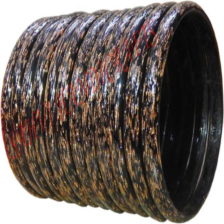

actual_output: 2
predicted_output: 2
image: 1


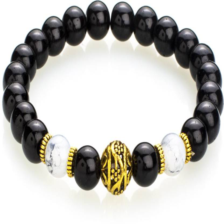

actual_output: 2
predicted_output: 2
image: 2


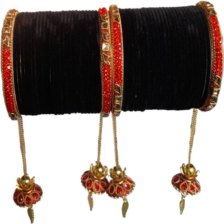

actual_output: 0
predicted_output: 0
image: 3


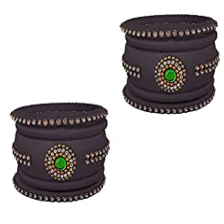

actual_output: 5
predicted_output: 5
image: 4


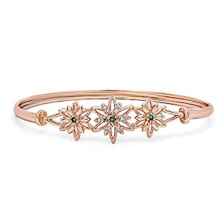

actual_output: 14
predicted_output: 14
image: 5


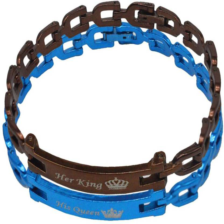

actual_output: 10
predicted_output: 10
image: 6


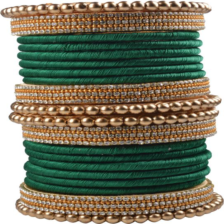

actual_output: 13
predicted_output: 13
image: 7


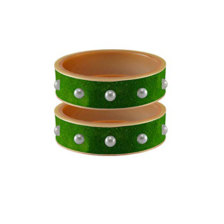

actual_output: 17
predicted_output: 17
image: 8


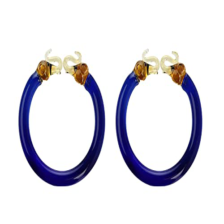

actual_output: 8
predicted_output: 8
image: 9


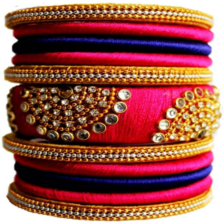

actual_output: 7
predicted_output: 21
image: 10


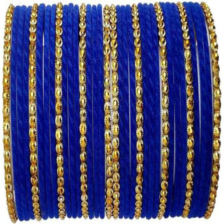

actual_output: 8
predicted_output: 8


In [14]:
def check_accuracy(loader,model):

    model.eval()

    with torch.no_grad():
#         if loader.dataset.train:
#             print("checking accuracy on training data")
#         else:
#             print("checking accuracy on test data")

        for x,y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            a = np.array(predictions.cpu())
            print(a)
            for i,img_array in enumerate(x):
                if i>10:
                    break
                print(f"image: {i}")
                img = transform(img_array)
                display(img)
                print(f"actual_output: {y[i]}")
                print(f"predicted_output: {a[i]}")
            break

# check_accuracy(train_loader,model)
check_accuracy(test_loader,model)

In [ ]:
# check image manually
from PIL import Image
img = Image.open('test1.png') 

In [ ]:
z=img.resize((224,224))
z1 = transforms.ToTensor()
z = z1(z).shape
z.reshape(1,3,224,224)

In [ ]:
score1 = model(z)